In [1]:
# pip install --upgrade torch

In [2]:
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

In simple terms: The model learns vector representations for words by predicting their co-occurrence relationships as described by the matrix.

$$
J = \sum_{i,j} f(X_{ij}) \left( w_i^\top w_j + b_i + b_j - \log X_{ij} \right)^2
$$

The gap between the prediction and the target

$$
\left( w_i^\top w_j + b_i + b_j - \log X_{ij} \right)^2
$$

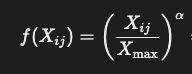

The weighting function that adjusts how much importance is given to each word pair (i,j) based on their co-occurrence frequency. The calculation is the amount of co-occurence / some hyperparameter (typically 10). The result is raised to the power of another hyper parameter, typically 0.75

* Xmax -  limits the impact of very frequent co-occurrences, preventing them from dominating trainingabs
* alpha - balances the scaling of weights, giving less frequent pairs a fair impact without overemphasizing rare ones.

$$
f(X_{ij})
$$

In [3]:
nltk.download("gutenberg")
nltk.download("punkt")

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/chen.m/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chen.m/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
def preprocess(sentence):
    sentence = " ".join(sentence).lower()  # Lowercase
    sentence = re.sub(r"[^a-z\s]", "", sentence)  # Remove punctuation
    return sentence

In [6]:
corpus = nltk.corpus.gutenberg.sents("austen-emma.txt")

corpus = [preprocess(sentence) for sentence in corpus]
tokenized_corpus = [sentence.split() for sentence in corpus]

In [7]:
def preprocess(sentence):
    sentence = " ".join(sentence).lower()  # Lowercase
    sentence = re.sub(r"[^a-z\s]", "", sentence)  # Remove punctuation
    return sentence

In [31]:
corpus[0]

' emma by jane austen  '

In [8]:
vocab = set(word for sentence in tokenized_corpus for word in sentence)
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [34]:
%%time
# Build the co-occurrence matrix
window_size = 2
co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

for sentence in tokenized_corpus:
    for idx, word in enumerate(sentence):
        word_idx = word_to_idx[word]
        start = max(idx - window_size, 0)
        end = min(idx + window_size + 1, len(sentence))
        for context_word in sentence[start:end]:
            if context_word != word:
                context_idx = word_to_idx[context_word]
                co_occurrence_matrix[word_idx, context_idx] += 1

CPU times: user 867 ms, sys: 44.6 ms, total: 911 ms
Wall time: 929 ms


In [35]:
print("Co-occurrence matrix shape:", co_occurrence_matrix.shape)

Co-occurrence matrix shape: (7096, 7096)


In [39]:
type(co_occurrence_matrix)

numpy.ndarray

In [10]:
corpus[0]

' emma by jane austen  '

In [11]:
len(corpus)

7752

In [12]:
class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloVe, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)

        # Initialize weights
        # nn.init.xavier_uniform_(self.word_embeddings.weight)
        # nn.init.xavier_uniform_(self.context_embeddings.weight)
        # nn.init.zeros_(self.word_biases.weight)
        # nn.init.zeros_(self.context_biases.weight)

    def forward(self, word_idx, context_idx):
        word_embed = self.word_embeddings(word_idx)
        context_embed = self.context_embeddings(context_idx)
        word_bias = self.word_biases(word_idx).squeeze()
        context_bias = self.context_biases(context_idx).squeeze()
        
        # Dot product + biases
        prediction = (word_embed * context_embed).sum(dim=1) + word_bias + context_bias
        return prediction


In [13]:
class GloVe(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloVe, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)

        # Initialize weights
        nn.init.uniform_(self.word_embeddings.weight, a=-0.5, b=0.5)  
        nn.init.uniform_(self.context_embeddings.weight, a=-0.5, b=0.5)
        nn.init.zeros_(self.word_biases.weight)
        nn.init.zeros_(self.context_biases.weight)

    def forward(self, word_idx, context_idx):
        word_embed = self.word_embeddings(word_idx)
        context_embed = self.context_embeddings(context_idx)
        word_bias = self.word_biases(word_idx).squeeze()
        context_bias = self.context_biases(context_idx).squeeze()
        
        # Dot product + biases
        prediction = (word_embed * context_embed).sum(dim=1) + word_bias + context_bias
        return prediction


In [14]:
def weighting_function(x, X_max=100, alpha=0.75):
    return torch.where(x < X_max, (x / X_max) ** alpha, torch.ones_like(x))

def glove_loss(prediction, log_co_occurrence, weights):
    return torch.sum(weights * (prediction - log_co_occurrence) ** 2)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [16]:
co_occurrence = torch.tensor(co_occurrence_matrix, dtype=torch.float32, device=device)
log_co_occurrence = torch.log(co_occurrence + 1)

In [18]:
# torch.nonzero is a PyTorch function that returns the indices of all non-zero elements in a tensor.
word_indices, context_indices = torch.nonzero(co_occurrence, as_tuple=True)
co_occurrence_values = co_occurrence[word_indices, context_indices]
weights = weighting_function(co_occurrence_values)

In [19]:
# Initialize model and optimizer
embedding_dim = 100
model = GloVe(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(word_indices, context_indices)
    
    # Compute loss
    loss = glove_loss(predictions, log_co_occurrence[word_indices, context_indices], weights)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

print("Training complete!")

Epoch 10, Loss: 30041.3711
Epoch 20, Loss: 6967.3604
Epoch 30, Loss: 3525.5100
Epoch 40, Loss: 2237.3035
Epoch 50, Loss: 1345.7761
Epoch 60, Loss: 1012.4763
Epoch 70, Loss: 797.9583
Epoch 80, Loss: 659.7769
Epoch 90, Loss: 559.8011
Epoch 100, Loss: 484.2773
Training complete!


In [21]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman"), ("deep", "learning"), ("fun", "amazing")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")


Cosine Similarities:
Similarity between 'king' and 'queen': -0.0300
Similarity between 'man' and 'woman': 0.4201
Words 'deep' or 'learning' not in vocabulary.
Words 'fun' or 'amazing' not in vocabulary.


In [22]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman"), ("deep", "learning"), ("fun", "amazing")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")



Cosine Similarities:
Similarity between 'king' and 'queen': -0.0300
Similarity between 'man' and 'woman': 0.4201
Words 'deep' or 'learning' not in vocabulary.
Words 'fun' or 'amazing' not in vocabulary.


In [23]:
# Extract embeddings
word_embeddings = model.word_embeddings.weight.detach().cpu().numpy()

# Cosine similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test pairs
test_pairs = [("king", "queen"), ("man", "woman")]

print("\nCosine Similarities:")
for word1, word2 in test_pairs:
    if word1 in word_to_idx and word2 in word_to_idx:
        vec1 = word_embeddings[word_to_idx[word1]]
        vec2 = word_embeddings[word_to_idx[word2]]
        sim = cosine_similarity(vec1, vec2)
        print(f"Similarity between '{word1}' and '{word2}': {sim:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not in vocabulary.")



Cosine Similarities:
Similarity between 'king' and 'queen': -0.0300
Similarity between 'man' and 'woman': 0.4201


$$
\begin{array}{|c|c|c|}
\hline
\textbf{Aspect} & \textbf{GloVe} & \textbf{Word2Vec} \\
\hline
\textbf{Training Approach} & \text{Uses a co-occurrence matrix and matrix factorization.} & \text{Predictive model using CBOW or Skip-Gram.} \\
\hline
\textbf{Data Utilization} & \text{Leverages entire corpus statistics for global context.} & \text{Processes word pairs iteratively in local contexts.} \\
\hline
\textbf{Training Efficiency} & \text{Slower due to large co-occurrence matrix decomposition.} & \text{Faster with a simpler predictive model.} \\
\hline
\textbf{Representation} & \text{Captures global semantic relationships.} & \text{Focuses on local contextual similarities.} \\
\hline
\textbf{Memory Usage} & \text{Requires more memory for storing a co-occurrence matrix.} & \text{Less memory-intensive with dynamic processing.} \\
\hline
\textbf{Performance} & \text{Excels in analogy and word similarity tasks.} & \text{Captures context-specific meanings better.} \\
\hline
\end{array}
$$


# Exercise

In [166]:
# !pip install spacy
# !python -m spacy download en_core_web_md

In [7]:
import spacy

# Load the English medium model with word vectors
nlp = spacy.load('en_core_web_md')

# Access word vectors
movie_vector = nlp('movie').vector
print(movie_vector)  # GloVe-like embedding for "movie"


OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [161]:
data = [
    ("I love this movie!", "positive"),
    ("This is the worst film I’ve ever seen.", "negative"),
    ("Absolutely fantastic experience.", "positive"),
    ("I hated it. Total waste of time.", "negative"),
    ("The plot was amazing and I enjoyed it a lot.", "positive"),
    ("Terrible acting and boring story.", "negative"),
]

In [162]:
# Create features (vectors) and labels
X = [nlp(text).vector for text, label in data]
y = [1 if label == "positive" else 0 for _, label in data] 

In [167]:
from datasets import load_dataset

In [168]:
# Load Yelp polarity dataset
dataset = load_dataset("yelp_polarity")
# dataset = load_dataset("amazon_polarity")

# Split into train and test sets
train_data = dataset["train"]
test_data = dataset["test"]

# Print an example
print(train_data[0])

README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

{'text': "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.", 'label': 0}


Once you have the data in the right format, put it into some classifier. Try a few different models, see what works best

If you have the time, try building a neural network that does the job